# Курсовой проект для курса "Python для Data Science" #
##### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).
##### Целевая переменная - Price
##### Метрика качества - R2 (коэффициент детерминации)
##### Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv  

Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).
##### Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

##### Описание датасета:
**Id** - идентификационный номер квартиры  
**DistrictId** - идентификационный номер района  
**Rooms** - количество комнат  
**Square** - площадь  
**LifeSquare** - жилая площадь  
**KitchenSquare** - площадь кухни  
**Floor** - этаж  
**HouseFloor** - количество этажей в доме  
**HouseYear** - год постройки дома  
**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности  
**Social_1, Social_2, Social_3** - социальные показатели местности  
**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья  
**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров  
**Price** - цена квартиры

**Содержание**
1. [Загрузка данных](#load)
2. [Анализ признаков и очистка данных](#analisys)
3. [Замена текстовых переменных](#text_to_digit)
4. [Проверка качества модели](#model_check)
5. [Создание новых признаков](#feature_creation)
6. [Создание модели](#model_creation)

## Загрузка данных <a class='anchor' id='load'>

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import random

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib InLine
%config InLine.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Оценка качества модели по R2 и постройка графиковграфик preds vs true
    
    train_true_values - Целевые значения предсказания выборки train
    train_pred_values - Предсказанные значения выборки train
    test_true_values - Целевые значения предсказания выборки test
    test_pred_values - Предсказанные значения выборки test
    
    """
    
    print('R2_train:\t' + str(round(r2_score(train_true_values, train_pred_values), 3)) + '\n'
          'R2_test:\t' + str(round(r2_score(test_true_values, test_pred_values), 3))
         )
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 8)
    ax1, ax2 = ax.flatten()
    
    ax1.scatter(x=train_pred_values, y=train_true_values)
    ax1.plot([0, train_true_values.max()], [0, train_true_values.max()], color='black')  # целевая диагональ, где true_values = pred_values
    ax1.set_xlim(0, train_true_values.max())
    ax1.set_ylim(0, train_true_values.max())
    ax1.set_xlabel('Predicted values', size=14)
    ax1.set_ylabel('True values', size=14)
    ax1.set_title('Train True vs Predicted values', size=20)
    
    ax2.scatter(x=test_pred_values, y=test_true_values)
    ax2.plot([0, test_true_values.max()], [0, test_true_values.max()], color='black')  # целевая диагональ
    ax2.set_xlim(0, test_true_values.max())
    ax2.set_ylim(0, test_true_values.max())
    ax2.set_xlabel('Predicted values', size=14)
    ax2.set_ylabel('True values', size=14)
    ax2.set_title('Test True vs Predicted values', size=20)

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Запишем исходные данные в переменные ***train*** & ***test*** и узнаем краткую аннотацию по ***train***, для определения типов данных и пропущенных значений.

In [4]:
train_path = 'train.csv'
test_path = 'test.csv'

In [5]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Из полученных данных видно, что в тренировочной выборке имеется 10 000 наблюдений. В выборке имеется пропущенные значения двух признаков (_LifeSquare_ ~20% и _Healthcare_1_ ~50%) и строковые признаки (_Ecology_2_, _Ecology_3_ и _Shops_2_).  
Для получения информации о природе данных, узнаем описательную статистику каждого числового признака.

## Анализ признаков и очистка данных<a class='anchor' id='analisys'>

Выбросы будем отрабатывать параллельно на обоих датасетах (_test_ и _train_) не соединяя их друг с другам, чтобы не ошибиться при разделении, но сначала узнаем похожа ли природа данных в них.

In [8]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [9]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Поведение данных близко.
- признаки _Ecology_1, Social_1, 2, 3, Healthcare_1, 2_ изменяются в одинаковых промежутках. Скорее всего в этих признаках нет выбросов.
- в обеих выборках в признаках _LifeSquare_ и _Healthcare_1_, причём примерно одинаковое количество, относительно их размера (**20%** и **40%** соответсвенно).

Начнём анализ с признака _Rooms_ имеет максимальное значение гораздо большее чем стандартное отклонение - что странно, но возможно, а также минимальное значение - 0, что не вписывается в бизнес-логику данных. Узнаем количество встречающихся значений.

In [10]:
train['Rooms'].value_counts(sort=True)

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Значения 6, 10, 19 похожи на выбросы, в то время как 0 - явный выброс. Посмотрим на значения в данных наблюдениях, так как их всего 4.

In [11]:
train.loc[train.Rooms >= 6, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


Предположения подтвердились. Значения являются выбросами. Это можно понять по общей площади (_Square_) и подозрительной схожести значений с площадью кухни (_KitchenSquare_). Нулевые занчения будем считать за студию и заменим на **1**, выбросы больше **6** заменим на **5**. Те же операции проведём с выборкой _test_.

In [12]:
train.loc[train.Rooms == 0, 'Rooms'] = 1
train.loc[train.Rooms >= 6, 'Rooms'] = 5
test.loc[test.Rooms == 0, 'Rooms'] = 1
test.loc[test.Rooms >= 6, 'Rooms'] = 5

Далее рассмотрим признаки площади (_Square, LifeSquare, KitchenSquare_):  
- все они имеют не удовлетворяющие бизнес-логике минимальное значения,  
- сильно выбивающиеся из выборки максимальные значения, которые не бьются между собой (сумма _LifeSquare и KitchenSquare_ должна быть близка к _Square_),
- у признака _LifeSquare_ отсутсвует около 20% значений.

1. Избавимся от выбросов, заменяя слишком маленькие и слишком большие значения на 10 и 90 квантили соответственно (Кроме _KitchenSquare_. В этом признаке построоим диаграмму, чтобы понять, на какие значения заменить);
2. Пропуски признака _LifeSquare_ заменим разностью признаков _Square_ и _KitchenSquare_, при этом признак _KitchenSquare_ умножим некий коэффициент, чтобы учитывать площадь, возможного балкона и т.д.

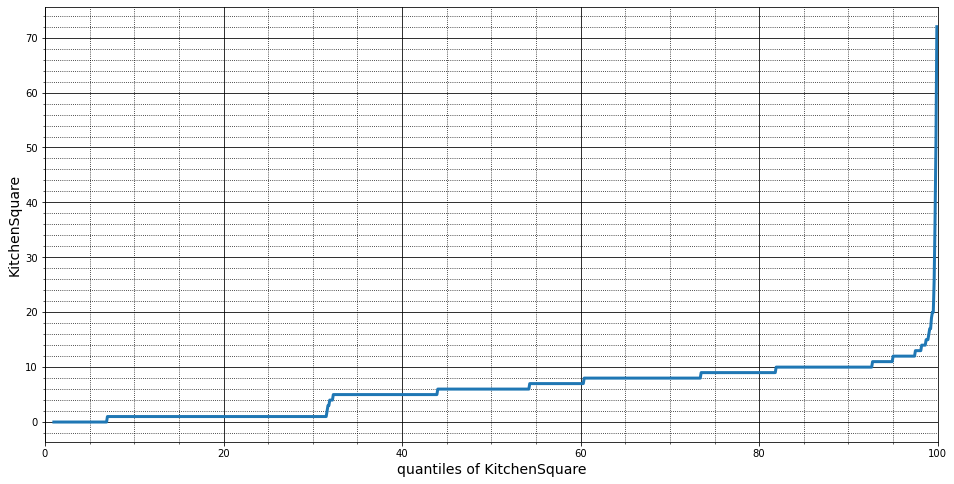

In [13]:
q = [np.percentile(train["KitchenSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantiles of KitchenSquare", size=14)
plt.ylabel("KitchenSquare", size=14)
plt.xlim(0, 100)
plt.minorticks_on()
plt.grid(which='major', color='k')
plt.grid(which='minor', color='k', linestyle=':')

Из графика видно, что адекватная нижняя граница, это квантиль **36**, адекватная высшая граница очень близка к **100**, поэтому возмьмём **99,5**

In [14]:
def drop_blowout(feat, min_q=.10, max_q=.90):  
    # Избавляет от выбросов в тренировочной и тестовой выборках методом "clip".
    # "feat" - название признака
    # "min_q" - минимальный квантиль
    # "min_q" - максимальный квантиль
    train[feat] = np.clip(
                        a=train[feat].dropna(),
                        a_min=train[feat].quantile(min_q),
                        a_max=train[feat].quantile(max_q)
    )
    test[feat] = np.clip(
                        a=train[feat].dropna(),
                        a_min=train[feat].quantile(min_q),
                        a_max=train[feat].quantile(max_q)
    )
drop_blowout('Square')
drop_blowout('LifeSquare')
drop_blowout('KitchenSquare', min_q=.36, max_q=.995)  # параметры были получены эмперическим путём

In [15]:
((train['Square'] - train['LifeSquare']) / train['KitchenSquare']).mean()

2.6762629534077234

Предполагаемый коэффициент около **2,7**, но так как его необходимо уменьшить, чтобы не вызывать отклонения от бизнес-логики, где сумма двух признаков _LifeSquare и KitchenSquare_ не были больше общей площади _Square_. Поэтому экспертным путём возьмем коэффициент за значение **2**.

In [16]:
mask = train[train['LifeSquare'].isnull()].index
train.loc[mask, 'LifeSquare'] = train.loc[mask, 'Square'] - train.loc[mask, 'KitchenSquare'] * 2
# Те же манипуляции для тестовой выборки
mask = test[test['LifeSquare'].isnull()].index
test.loc[mask, 'LifeSquare'] = test.loc[mask, 'Square'] - test.loc[mask, 'KitchenSquare'] * 2

Во время наших преобразований, сумма признаков _LifeSquare_ и _KitchenSquare_, возможно, превышает значение признака _Square_, поэтому понизим значение признака _LifeSquare_ в таких случаях.

In [17]:
mask = train[train['LifeSquare'] + train['KitchenSquare'] > train['Square']].index
train.loc[mask, 'LifeSquare'] =  train.loc[mask, 'Square'] - train.loc[mask, 'KitchenSquare']
# Те же манипуляции для тестовой выборки
mask = test[test['LifeSquare'].isnull()].index
test.loc[mask, 'LifeSquare'] = test.loc[mask, 'Square'] - test.loc[mask, 'KitchenSquare']

Далее рассмотрим признаки _Floor_ и _HouseFloor_. В первом приближении, признак _HouseFloor_ имеет выбросы (**0** и **117**), также необходимо проверить нет ли наблюдений, где значение признака _Floor_ , больше значения признака _HouseFloor_.
1. Посмотрим возможные значения признака _HouseFloor_ для определения дополнительных выбросов и заменим их на медиану;
2. Заменить значение признака _Floor_ на случайный от 1 до _HouseFloor_, если значение _Floor_ выше.

In [18]:
train['HouseFloor'].sort_values().unique(), test['HouseFloor'].sort_values().unique(),

(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
        48., 99.]))

In [19]:
mask = train[(train['HouseFloor'] == 0) | (train['HouseFloor'] >= 48)].index
train.loc[mask, 'HouseFloor'] = train['HouseFloor'].median()
mask = test[(test['HouseFloor'] == 0) | (test['HouseFloor'] >= 48)].index
test.loc[mask, 'HouseFloor'] = test['HouseFloor'].median()

In [20]:
train[train['HouseFloor'] < train['Floor']].value_counts().sum()

829

In [21]:
mask = train[train['HouseFloor'] < train['Floor']].index
train.loc[mask, 'Floor'] = train.loc[mask, 'HouseFloor'].apply(lambda x: random.randint(1, x))
mask = test[test['HouseFloor'] < test['Floor']].index
test.loc[mask, 'Floor'] = test.loc[mask, 'HouseFloor'].apply(lambda x: random.randint(1, x))

Далее рассмотрим признак _HouseYear_. Судя по максимальному восьмизначному значению, имеются данные, не удовлетворяющие бизнес-логике (Дом должен быть построен не позднее текущего года). Необходимо проверить количество выбросов.

In [22]:
train['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

Только два значения не удовлетворяют бизнес-логике, заменим их на значение **2020**.

In [23]:
train.loc[train['HouseYear'] > 2020, 'HouseYear'] = 2020
test.loc[test['HouseYear'] > 2020, 'HouseYear'] = 2020

Необходимо заполнить пропуски признака _Healthcare_1_. Так как отсутсвующих данных почти половина (**40%**), присваивание значений в этих наблюдениях на константу - неправильно. Заменим на случайные числа нормального распределения со средним и стандартным отклоненем присущим нашей выборке.

In [24]:
mask = train[train['Healthcare_1'].isnull()].index
train.loc[mask, 'Healthcare_1'] = random.normalvariate(mu=train['Healthcare_1'].mean(), sigma=train['Healthcare_1'].std())
mask = test[test['Healthcare_1'].isnull()].index
test.loc[mask, 'Healthcare_1'] = random.normalvariate(mu=test['Healthcare_1'].mean(), sigma=test['Healthcare_1'].std())

## Замена текстовых переменных<a class='anchor' id='text_to_digit'>
В выборках имеются текстовые переменные. Необходимо заменить их на числовые для использования в модели. Так как данные признаки имеют два возможных значения, нет необходимости в использовании dummy-переменных. Изменим значения в самих признаках.

In [25]:
obj_feat = train.select_dtypes(include='object')
for i in obj_feat.columns:
    print(f'{i}:\t {obj_feat[i].value_counts().index.to_list()}')

Ecology_2:	 ['B', 'A']
Ecology_3:	 ['B', 'A']
Shops_2:	 ['B', 'A']


In [26]:
train.select_dtypes(include='object').replace({'A': 0, 'B': 1}, inplace=True)
for feat in obj_feat.columns:
    train[f'{feat}_bin'] = train[f'{feat}'].replace({'A': 0, 'B': 1})
    test[f'{feat}_bin'] = test[f'{feat}'].replace({'A': 0, 'B': 1})

In [27]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888800,55.127098,37.199583,7.08490,7.396600,12.924500,1984.872400,0.118858,24.687000,5352.157400,8.039200,1276.959524,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,4859.01902,43.587592,0.813819,14.841385,13.849201,2.54993,5.015997,6.221581,18.416347,0.119025,17.532614,4006.799803,23.831875,749.842127,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.00000,0.000000,1.000000,36.992781,10.089322,5.00000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,25.041556,5.00000,3.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513310,33.957899,6.00000,6.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1422.302259,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,12592.50000,75.000000,2.000000,65.900625,47.367319,9.00000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1422.302259,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,16798.00000,209.000000,5.000000,80.855915,70.855915,20.00000,37.000000,47.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


## Проверка качества модели<a class='ancor' id='model_check'>

Проверим текущее качество модели, используя **Линейную регрессию**.

In [28]:
feat_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
              'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_bin', 
              'Ecology_3_bin', 'Shops_2_bin']
target_name = 'Price'
X = train[feat_names]
y = train[target_name]

R2_train:	0.542
R2_test:	0.523


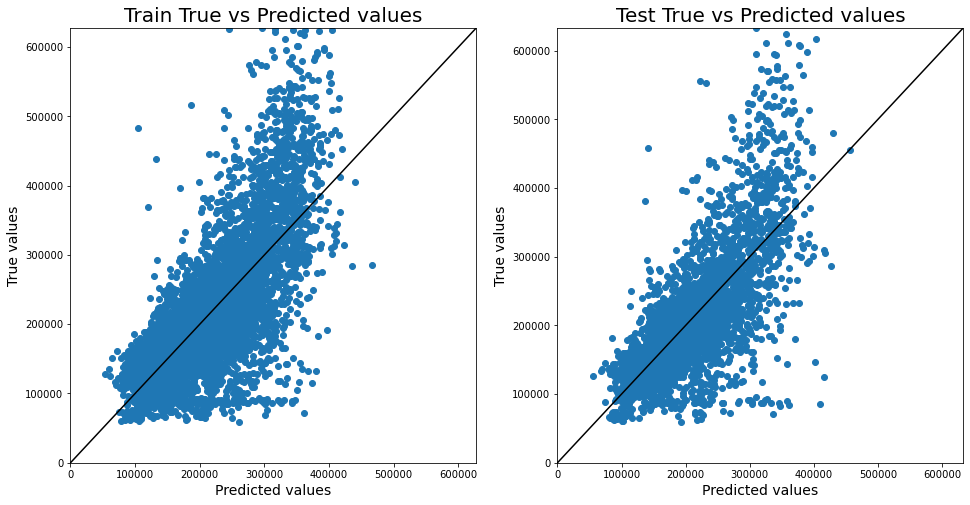

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
y_valid_pred = lr_model.predict(X_valid)
evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

Модель стабильна, но текущий показатель парметра **R2** ниже целевого. Возможно, если использовать другую модель, качество вырастет, но также есть возможность создания новых признаков, которые также могут увеличить заданную метрику качества.

## Создание новых признаков<a class='anchor' id='feature_creation'>

#### DistrictSize
По признаку _DistrictId_ узнаем, какое количество квартир продаётся в каждом из районов, метрика косвенно отражает величину спроса на квартиры, что влияет на целевую переменную, _Цену_.

In [30]:
DistrictSize = train['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
train = pd.merge(left=train, right=DistrictSize, on='DistrictId', how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,1422.302259,0,11,B,184966.930730,1,1,1,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.000000,1,16,B,300009.450063,1,1,1,87
2,4765,53,2.0,44.947953,29.197612,5.0,8,12.0,1968,0.049637,...,0,229.000000,1,3,B,220925.908524,1,1,1,174
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977,0.437885,...,3,1084.000000,0,5,B,175616.227217,1,1,1,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.000000,2,4,B,150226.531644,1,1,1,97


In [31]:
# То же самое для выборки test
DistrictSize = test['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
test = pd.merge(left=test, right=DistrictSize, on='DistrictId', how='left')

#### is_DistrictLarge
Признак, обозначающий большой ли кваратал. Порог - **200** (получен эмперическим путём из графика ниже)

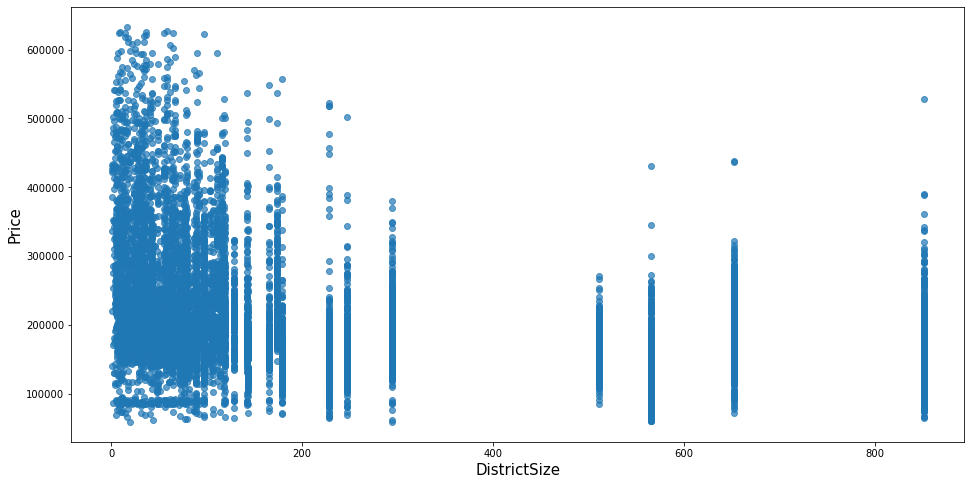

In [32]:
plt.figure(figsize=(16, 8))
plt.scatter(x=train["DistrictSize"], y=train["Price"], alpha=0.7)
plt.xlabel("DistrictSize", size=15)
plt.ylabel("Price", size=15)
plt.show()

In [33]:
train['is_LargeDistrict'] = (train['DistrictSize'] > 200).astype(int)
test['is_LargeDistrict'] = (test['DistrictSize'] > 200).astype(int)

#### ToiletSquare
С помощью признаков _Square, LifeSquare и KitchenSquare_, вычислим среднюю нежелую площадь в квартире, гипотетически - это площадь туалета.

In [34]:
train['ToiletSquare'] = train['Square'] - train['LifeSquare'] - train['KitchenSquare']
test['ToiletSquare'] = test['Square'] - train['LifeSquare'] - test['KitchenSquare']

#### RoomSquare_mean
С помощью признаков _Square, KitchenSquare и ToiletSquare_, вычислим среднюю площадь комнат в квартире, как правило в дешёвых квартирах, средняя площадь комнат - меньше, значит имеется кореляция.

In [35]:
train['RoomSquare_mean'] = (train['LifeSquare']) / train['Rooms']
test['RoomSquare_mean'] = (test['LifeSquare']) / test['Rooms']

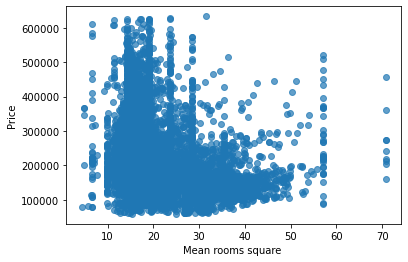

In [36]:
plt.scatter(x=train['RoomSquare_mean'], y=y, alpha = 0.7)
plt.xlabel('Mean rooms square ')
plt.ylabel('Price')
plt.show()

Судя по графику, видно, что некая зависимость есть, также введём дополнительный признак, который разделяет облако точек на два кластера, больше и меньше 50 квадратных метров

#### is_BigRooms

In [37]:
train['is_BigRooms'] = (train['RoomSquare_mean'] > 50).astype(int)
test['is_BigRooms'] = (test['RoomSquare_mean'] > 50).astype(int)
train['is_BigRooms'].value_counts()

0    9938
1      62
Name: is_BigRooms, dtype: int64

#### Mean_Square_by_rooms, diff_square_and_mean_square_by_rooms, ratio_square_and_mean_square_by_rooms, bigger_then_mean
_Mean_Square_by_rooms_ - средняя площадь для квартир с таким же количеством комнат.  
_diff_square_and_mean_square_by_rooms_ - Разница площади квартиры и средней площади для квартир с таким же количеством комнат.  
_ratio_square_and_mean_square_by_rooms_ - Отношение площади квартиры и средней площади для квартир с таким же количеством комнат.  
_bigger_then_mean_ - Является ли площадь квартиры больше средней площади для квартир с таким же количеством комнат.

In [38]:
gp = train.groupby(["Rooms"])["Square"].mean()
train["Mean_Square_by_rooms"] = train["Rooms"].map(gp.to_dict())

train["diff_square_and_mean_square_by_rooms"] = train["Square"] - train["Mean_Square_by_rooms"]
train["ratio_square_and_mean_square_by_rooms"] = train["Square"] / train["Mean_Square_by_rooms"] - 1

train["bigger_then_mean"] = np.where(
    train["diff_square_and_mean_square_by_rooms"] > 0, 1, 0)

gp = test.groupby(["Rooms"])["Square"].mean()
test["Mean_Square_by_rooms"] = test["Rooms"].map(gp.to_dict())

test["diff_square_and_mean_square_by_rooms"] = test["Square"] - test["Mean_Square_by_rooms"]
test["ratio_square_and_mean_square_by_rooms"] = test["Square"] / test["Mean_Square_by_rooms"] - 1

test["bigger_then_mean"] = np.where(
    test["diff_square_and_mean_square_by_rooms"] > 0, 1, 0)

#### RoofProximity
Признак, отражающий отношение этажа квартиры (_Floor_) и этажности здания (_HouseFloor_), скорее всего, чем ближе квартира к верхним этажам, тем она дороже

In [39]:
train['RoofProximity'] = train['Floor'] / train['HouseFloor']
test['RoofProximity'] = test['Floor'] / test['HouseFloor']

#### Floor_relative_max_floorYear
Признак, который показывает отношение этажности дома к максимальной этажности в год.

In [40]:
mean_floor = train.groupby('HouseYear')['HouseFloor'].mean()
train['mean_floor_in_year'] = train['HouseYear'].map(mean_floor.to_dict())
mean_floor = test.groupby('HouseYear')['HouseFloor'].mean()
test['mean_floor_in_year'] = test['HouseYear'].map(mean_floor.to_dict())
train['Floor_relative_max_floorYear'] = train['HouseFloor'] / train['mean_floor_in_year']
test['Floor_relative_max_floorYear'] = test['HouseFloor'] / test['mean_floor_in_year']

#### is_oldHouse
Признак, отделяющий старые дома от новых. Порог - **50**. (получен эмперическим путём из точечной диаграммы ниже)

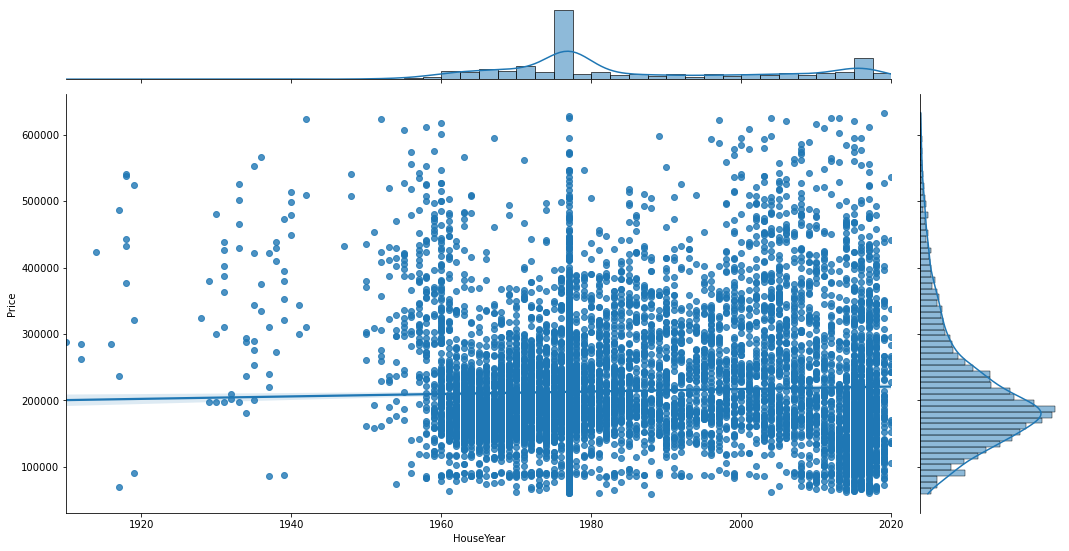

In [41]:
grid = sns.jointplot(train['HouseYear'], train['Price'], kind='reg')
grid.fig.set_figwidth(16)
grid.fig.set_figheight(8)
plt.show()

In [42]:
train['is_oldHouse'] = (train['HouseYear'] > 50).astype(int)
test['is_oldHouse'] = (test['HouseYear'] > 50).astype(int)

#### is_toxicDistrict
По среднему значению признака _Ecology_1_ для каждого квартала посчитаем среднюю "токсичность" и разделим на два класстера. Пороговое значение - **0.25** по признаку _Ecology_1_ (Получено эмперическим путём из диаграммы ниже)

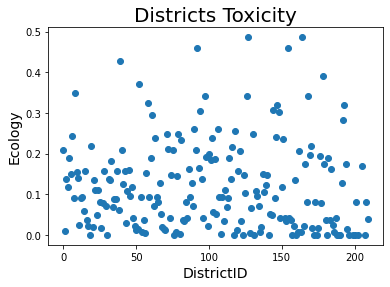

In [43]:
district_ecology = train.groupby('DistrictId', as_index=False).agg({'Ecology_1': 'mean'})
plt.scatter(x=district_ecology['DistrictId'], y=district_ecology['Ecology_1'])
plt.title('Districts Toxicity', size=20)
plt.xlabel('DistrictID', size=14)
plt.ylabel('Ecology', size=14)
plt.show()

In [44]:
district_ecology['is_toxicDistrict'] = (district_ecology['Ecology_1'] > 0.25).astype(int)
district_ecology.drop(columns='Ecology_1', inplace=True)
train = pd.merge(left=train, right=district_ecology, on='DistrictId', how='left')
test = pd.merge(left=test, right=district_ecology, on='DistrictId', how='left')
test['is_toxicDistrict'] = test['is_toxicDistrict'].fillna(0)  # Если этот квартал нам не встречался, будем считать его не токсичным

In [45]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 2.71 MB
Memory usage after optimization is: 0.94 MB
Decreased by 65.1%


In [46]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 1.34 MB
Memory usage after optimization is: 0.47 MB
Decreased by 65.0%


In [47]:
train.select_dtypes(exclude='category').columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price',
       'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin', 'DistrictSize',
       'is_LargeDistrict', 'ToiletSquare', 'RoomSquare_mean', 'is_BigRooms',
       'Mean_Square_by_rooms', 'diff_square_and_mean_square_by_rooms',
       'ratio_square_and_mean_square_by_rooms', 'bigger_then_mean',
       'RoofProximity', 'mean_floor_in_year', 'Floor_relative_max_floorYear',
       'is_oldHouse', 'is_toxicDistrict'],
      dtype='object')

In [48]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 
                 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_bin', 
                 'Ecology_3_bin', 'Shops_2_bin', 'DistrictSize', 'is_LargeDistrict', 'ToiletSquare', 'RoomSquare_mean', 
                 'is_BigRooms', 'RoofProximity', 'is_oldHouse', 'is_toxicDistrict', 'Floor_relative_max_floorYear', 
                 'mean_floor_in_year', 'Mean_Square_by_rooms', 'diff_square_and_mean_square_by_rooms',
                 'ratio_square_and_mean_square_by_rooms', 'bigger_then_mean']

R2_train:	0.611
R2_test:	0.601


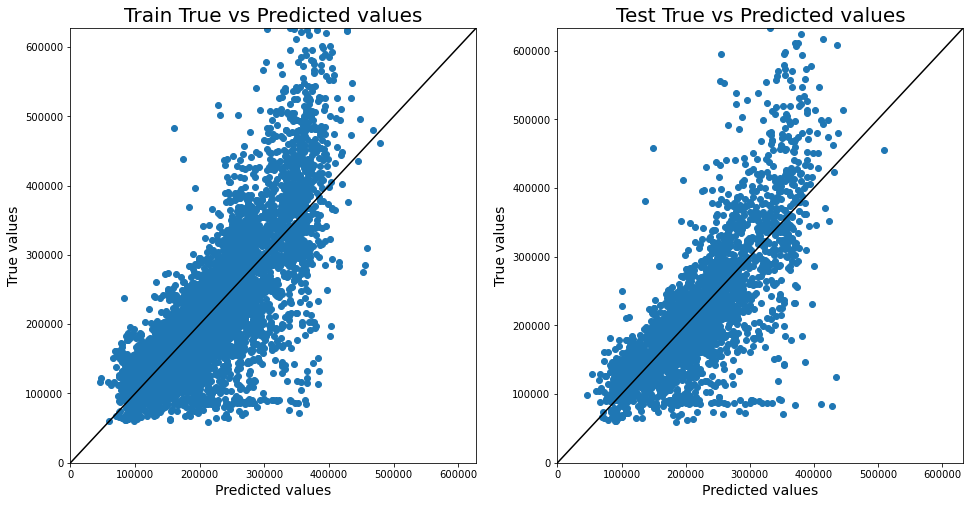

In [49]:
X = train[feature_names]
y = train[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

lr_model.fit(X_train, y_train)
y_valid_pred = lr_model.predict(X_valid)
y_train_pred = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

С помощью добавлений новых признаков, удалось увелить метрику качества на 8% и уменьшить переобучение. Перед построением модели, ещё раз удостоверимся, что пропусков нет

In [50]:
train.isnull().sum().sum() + test.isnull().sum().sum()

0

## Создание модели<a class='anchor' id='model_creation'>

In [51]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=3,
                                     max_features=5,
                                     min_samples_leaf=10,
                                     random_state=42,
                                     n_estimators=250)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_features=5, min_samples_leaf=10,
                          n_estimators=250, random_state=42)

R2_train:	0.796
R2_test:	0.714


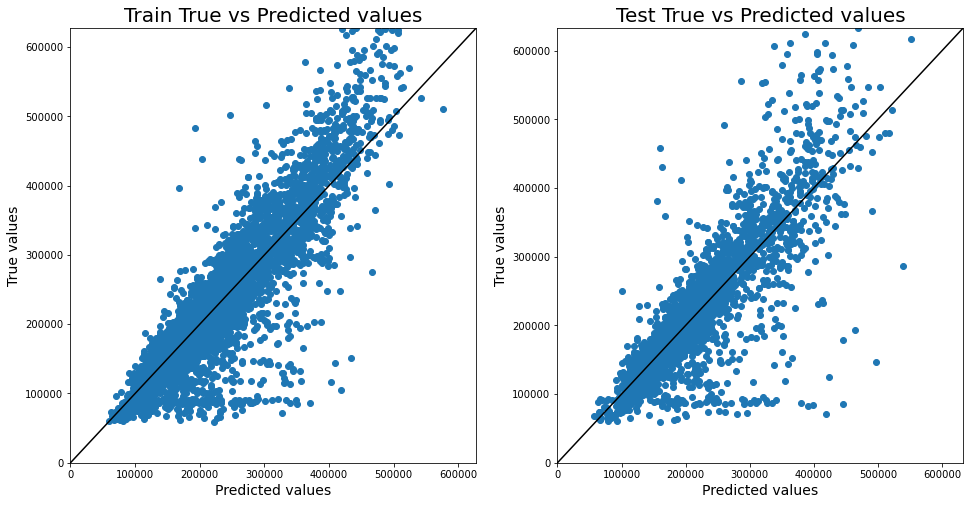

In [52]:
y_train_pred = gb_model.predict(X_train)
y_valid_pred = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

In [53]:
cv_score = cross_val_score(
    gb_model,
    X[feature_names],
    y,
    scoring='r2',
    cv=KFold(n_splits=4, shuffle=True, random_state=1)
)
print(str(cv_score) + '\n' + str(cv_score.mean()) + '\n' + str(cv_score.std()))

[0.72715333 0.72868413 0.74376404 0.72193309]
0.7303836486162183
0.008120502018273376


### Предсказание на тестовой выборке и запись в файл<a class='anchor' id='prediction'>

In [54]:
y_test = pd.DataFrame(gb_model.predict(test[feature_names]), columns=['Price'])

In [55]:
y_test

,Price
0,184992.055700
1,279908.512564
2,332761.336743
3,243420.116441
4,116725.002134
...,...
4995,346795.761307
4996,202086.048778
4997,274753.676802
4998,245358.521340


In [56]:
y_test.to_csv('AGArtyomov_predictions.csv', index=False, encoding='utf-8', sep=';')

In [57]:
check_csv = pd.read_csv('AGArtyomov_predictions.csv')
check_csv

,Price
0,184992.055700
1,279908.512564
2,332761.336743
3,243420.116441
4,116725.002134
...,...
4995,346795.761307
4996,202086.048778
4997,274753.676802
4998,245358.521340
